In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:

#hide
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.IMAGENETTE)

In [4]:
im_stats = [*imagenet_stats]
im_stats

[[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

In [5]:
def get_imagenette_dls(bs, size):
  imnet = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    item_tfms = Resize(460),
                    batch_tfms = [*aug_transforms(size=size, min_scale=0.75),
                                  Normalize.from_stats(*imagenet_stats)]
  )

  return imnet.dataloaders(path, bs=bs)

In [6]:
path

Path('/root/.fastai/data/imagenette2')

In [7]:
dls = get_imagenette_dls(64, 224)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.00015848931798245758)

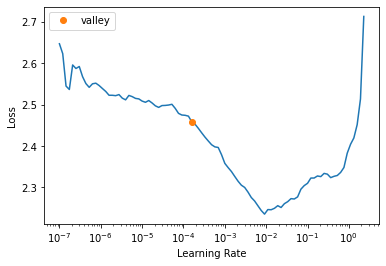

In [8]:
# train a blank model 
model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

In [9]:
# fit the entire model for 5 epochs with the new lr
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.841481,1.634431,0.427931,03:20
1,1.360799,1.250425,0.603809,03:21
2,1.072050,0.931889,0.697535,03:21
3,0.919540,0.824963,0.748320,03:20
4,0.848013,0.783724,0.756908,03:21


## Progressive Resizing

SuggestedLRs(valley=0.0002290867705596611)

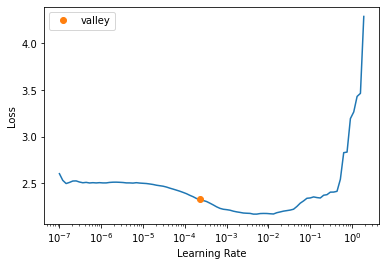

In [10]:
# implement progressive resizing with the same model and see if it is better
dls = get_imagenette_dls(128, 128)
model_2 = xresnet50(n_out=dls.c)
learn = Learner(dls, model_2, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.lr_find()

In [11]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.589526,1.823611,0.503734,03:03
1,1.223397,1.343979,0.578417,03:04
2,0.900740,0.760638,0.751307,03:05


SuggestedLRs(valley=0.0004786300996784121)

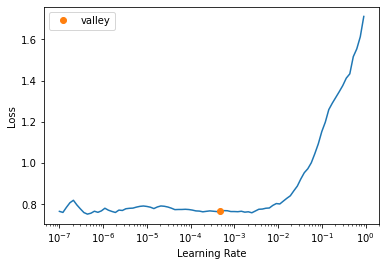

In [12]:
# increase image size and decrease batch size
dls = get_imagenette_dls(64, 224)
learn.lr_find()

In [13]:
# apply transfer learning approach 
learn.fine_tune(3, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.766911,0.811830,0.751307,03:04


epoch,train_loss,valid_loss,accuracy,time
0,0.713242,0.694399,0.781553,03:04
1,0.655954,0.665772,0.785287,03:05
2,0.625331,0.637427,0.795743,03:08


## TTA

In [14]:
# see if we get better accuracy with test time augmentation on the valdiation set
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.8077)

## Mixup and Label Smoothing
- train a model from scratch using mixup, another using label smoothing, and another combining both


In [15]:
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.915911,2.345965,0.399552,05:55
1,1.633609,1.235714,0.581777,05:57
2,1.386902,0.884044,0.717326,05:56
3,1.216197,0.759218,0.772591,05:57


In [16]:
# see if we get better accuracy with test time augmentation on the valdiation set after mixup
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.7898)

- To see better results with MixUp, we likely need to train for more epochs

In [17]:
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.759637,1.773289,0.474234,05:56
1,1.401663,1.485612,0.617998,05:56


epoch,train_loss,valid_loss,accuracy,time
0,1.759637,1.773289,0.474234,05:56
1,1.401663,1.485612,0.617998,05:56
2,1.180420,1.209459,0.726288,05:55
3,1.046575,1.015919,0.813294,05:56


In [18]:
# see if we get better accuracy with test time augmentation on the valdiation set after label smoothing
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.8163)

- Combine both to see how it affects model results

In [ ]:
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(4, 3e-3)

In [ ]:
# see if we get better accuracy with test time augmentation on the valdiation set after ixup and label smoothing
preds, targs = learn.tta()
accuracy(preds, targs)